In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pymongo
import os

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sentence_transformers import SentenceTransformer

In [85]:
%%time
# Read in the s&p dataset
stocks = pd.read_csv('sp500.csv')

CPU times: total: 15.6 ms
Wall time: 12 ms


In [87]:
# Remove some columns that won't be used
stocks.drop(['longnamesort','prices','esgrating','logo'], inplace=True, axis=1)
stocks.to_csv("stock_data.csv", encoding='utf-8', index=False)

In [92]:
# Create array X of the all long business summaries
X = np.array(stocks.longbusinesssummary)


In [93]:
# Encode the textual data from X into vectors so that we can compute the cosine distance
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)
embed_data = embeddings

Batches: 100%|██████████| 16/16 [00:41<00:00,  2.59s/it]


In [94]:
X = np.array(embed_data)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

,0,1,2,3,4
0,-1.094544,-3.025239,1.445596,-0.679059,-0.555109
1,-1.318473,-1.289031,-2.584346,-1.628635,3.127696
2,-2.478817,-1.561214,-4.145496,-0.558103,2.921870
3,-2.174768,-1.666612,-3.896374,0.295161,3.529427
4,-4.333916,0.252640,2.797513,1.588013,1.798735


Recommender function taken in modified form from:https://towardsdatascience.com/hands-on-content-based-recommender-system-using-python-1d643bf314e4

In [96]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))
cos_sim_data.to_csv("cosine_sim_data.csv", encoding='utf-8', index=False)


def give_recommendations(index, print_recommendation=False, print_recommendation_longbusinesssummary=False, print_sectors=False):
    index_recomm = cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:21]
    stocks_recomm = stocks['symbol'].loc[index_recomm].values
    result = {'Stocks': stocks_recomm, 'Index': index_recomm}
    if print_recommendation == True:
        print('The watched stock is this one: %s \n' %(stocks['symbol'].loc[index]))
        k = 1
        for stock in stocks_recomm:
            print('The number %i recommended stock is this one: %s \n' %(k, stock))
    if print_recommendation_longbusinesssummary == True:
        print('The longbusinesssummary of the watched stock is this one:\n %s \n' %(stocks['longbusinesssummary'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['longbusinesssummary'].loc[index_recomm[q]]
            print('The longbusinesssummary of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    if print_sectors == True:
        print('The sector of the watched stock is this one:\n %s \n' %
              (stocks['sector'].loc[index]))
        k = 1
        for q in range(len(stocks_recomm)):
            plot_q = stocks['sector'].loc[index_recomm[q]]
            print('The sector of the number %i recommended stock is this one:\n %s \n' % (
                k, plot_q))
            k = k+1
    return result

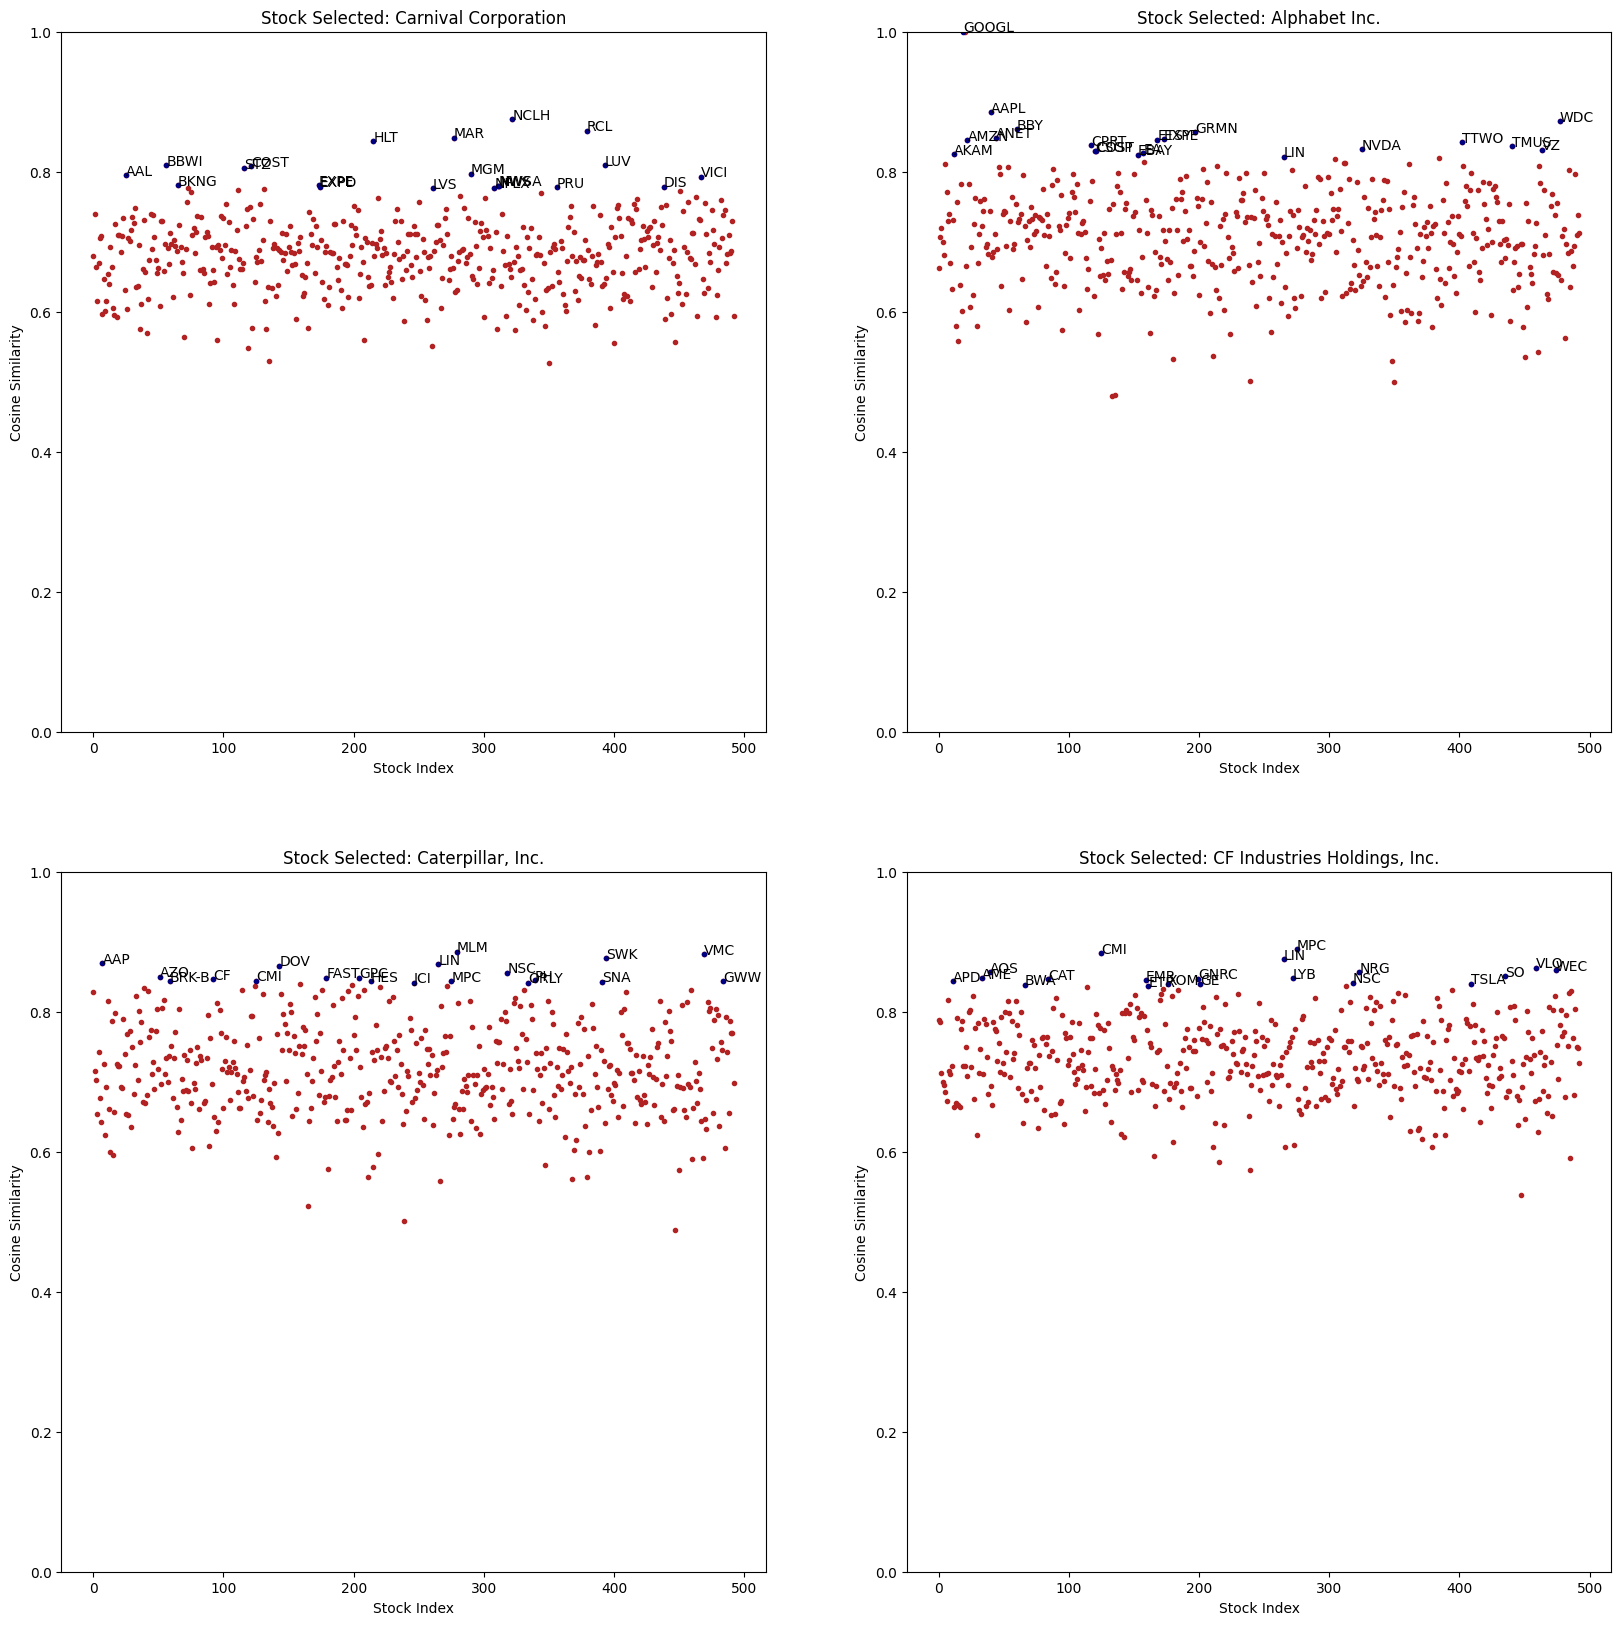

In [97]:
# Randomly selects 4 companies and calculates the top 20 recommendations for each. This is also plotted to visually show cosine sim.
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Stocks']
  plt.plot(x,y,'.',color='navy',label='Recommended Stocks')
  plt.title('Stock Selected: '+stocks['shortname'].loc[index])
  plt.xlabel('Stock Index')
  k=0
  for x_i in x:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

In [98]:
# Test recommendation on one specific company (AAPL)
give_recommendations(40,True, True, True)

The watched stock is this one: AAPL 

The number 1 recommended stock is this one: GOOG 

The number 1 recommended stock is this one: GOOGL 

The number 1 recommended stock is this one: WDC 

The number 1 recommended stock is this one: GRMN 

The number 1 recommended stock is this one: BBY 

The number 1 recommended stock is this one: TMUS 

The number 1 recommended stock is this one: CE 

The number 1 recommended stock is this one: STX 

The number 1 recommended stock is this one: NXPI 

The number 1 recommended stock is this one: NVDA 

The number 1 recommended stock is this one: QRVO 

The number 1 recommended stock is this one: MCHP 

The number 1 recommended stock is this one: VZ 

The number 1 recommended stock is this one: SWKS 

The number 1 recommended stock is this one: INTC 

The number 1 recommended stock is this one: HPQ 

The number 1 recommended stock is this one: AVY 

The number 1 recommended stock is this one: MSI 

The number 1 recommended stock is this one: TTWO 

Th

{'Stocks': array(['GOOG', 'GOOGL', 'WDC', 'GRMN', 'BBY', 'TMUS', 'CE', 'STX', 'NXPI',
        'NVDA', 'QRVO', 'MCHP', 'VZ', 'SWKS', 'INTC', 'HPQ', 'AVY', 'MSI',
        'TTWO', 'ANET'], dtype=object),
 'Index': [20,
  19,
  477,
  197,
  60,
  440,
  88,
  384,
  327,
  325,
  361,
  291,
  463,
  390,
  231,
  221,
  53,
  304,
  402,
  44]}

Record recommendation results into Pandas DF

In [99]:
recomm_list = []
for i in range(len(X)):
    recomm_i = give_recommendations(i)
    recomm_list.append(recomm_i['Stocks'])
recomm_data = pd.DataFrame(recomm_list, columns=['1', '2', '3', '4', '5', ' 6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])
recomm_data['Target'] = stocks['symbol']
recomm_data = recomm_data[['Target', '1', '2', '3', '4', '5', ' 6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']]


In [100]:
# Print sample of dataframe
recomm_data.sample(frac=1).head()

,Target,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
20,GOOG,GOOGL,AAPL,WDC,BBY,GRMN,ANET,EXPE,ETSY,AMZN,...,CPRT,TMUS,NVDA,VZ,COST,CSGP,EA,AKAM,EBAY,LIN
71,BR,STT,FISV,FIS,PFG,C,MS,RJF,BAC,MA,...,SCHW,CMA,NTRS,NDAQ,USB,OMC,MSCI,CSGP,CME,GPN
38,AON,MMC,PFG,OMC,L,CME,STT,BR,ACN,RE,...,J,HIG,SCHW,PKI,AIZ,NTRS,DGX,PRU,MSCI,CI
67,BXP,HST,KIM,PLD,UDR,AMT,VICI,ESS,ARE,MAA,...,WY,AVB,SPG,IRM,REG,DRE,VNO,PHM,EQR,PSA
307,NTAP,NOW,FFIV,CTXS,LUMN,ANET,ORCL,AKAM,ADP,IBM,...,ROP,DXC,STX,CSGP,HPE,FTNT,ZBRA,FIS,INTU,CSCO


In [101]:
# Write dataframe to .csv
recomm_data.to_csv("cosine_sim.csv", encoding='utf-8', index=False)

Reading in user data from Mongo

In [102]:
from pymongo import MongoClient
from dotenv import load_dotenv
load_dotenv()
mongo_uri = os.getenv('MONGO_URI')

# Setting the MongoDB connection
mongoClient = MongoClient(mongo_uri)
db = mongoClient.test
collection = db['user-data']

user_data = collection.find_one({"email":"recommender_test@gmail.com"})
user_query = user_data['stocks']
user_query = user_query[0]
print(user_query)

MMM


Query csv based on a stock the user owns

In [103]:
stocks.iloc[:,2]
stock_indexes = stocks.iloc[:,2]
stock_indexes = stock_indexes.values

In [104]:
i = list(stock_indexes)
user_recommendations = give_recommendations(i.index(user_query))

In [105]:
type(user_recommendations)
user_recommendations["Stocks"]

array(['JCI', 'CLX', 'GE', 'HWM', 'CTSH', 'SLB', 'BKR', 'DOW', 'VMC',
       'IR', 'DOV', 'BWA', 'STE', 'ETN', 'WHR', 'DD', 'FTV', 'EMR', 'SWK',
       'CTLT'], dtype=object)

In [106]:
print("For user owned stock:", user_query, "the top 20 recommendations are:", user_recommendations["Stocks"])

For user owned stock: MMM the top 20 recommendations are: ['JCI' 'CLX' 'GE' 'HWM' 'CTSH' 'SLB' 'BKR' 'DOW' 'VMC' 'IR' 'DOV' 'BWA'
 'STE' 'ETN' 'WHR' 'DD' 'FTV' 'EMR' 'SWK' 'CTLT']


In [107]:
new_user_recommendations = user_recommendations["Stocks"]
final_recs = new_user_recommendations[0:20]
final_recs = final_recs.tolist()
print(final_recs)

['JCI', 'CLX', 'GE', 'HWM', 'CTSH', 'SLB', 'BKR', 'DOW', 'VMC', 'IR', 'DOV', 'BWA', 'STE', 'ETN', 'WHR', 'DD', 'FTV', 'EMR', 'SWK', 'CTLT']


In [108]:
collection.update_one({"email":"recommender_test@gmail.com"}, {"$set": {"recommended_stocks": final_recs}})